# IA para Manuteção Preditiva usando Redes Neurais

### Importar Bibliotecas

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

### Importar Dataset

Segue abaixo link para acessar a base de dados:

https://www.kaggle.com/behrad3d/nasa-cmaps

In [30]:
dataset_train=pd.read_csv('../input/PM_train.txt',sep=' ',header=None).drop([26,27],axis=1)
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns=col_names
print('Ver dataset de treino: ',dataset_train.shape)
dataset_train.head()

Ver dataset de treino:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [31]:
dataset_test=pd.read_csv('../input/PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
dataset_test.columns=col_names
print('Ver dataset de teste: ',dataset_train.shape)
dataset_train.head()

Ver dataset de teste:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [32]:
pm_truth=pd.read_csv('../input/PM_truth.txt',sep=' ',header=None).drop([1],axis=1)
pm_truth.columns=['more']
pm_truth['id']=pm_truth.index+1
pm_truth.head()

,more,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [33]:
# gerar coluna máxima para dados de teste
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [34]:
# rodando a falha 
pm_truth['rtf']=pm_truth['more']+rul['max']
pm_truth.head()

,more,id,rtf
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [35]:
#Trazer uma coluna ciclo de trás para frente para identificar o ciclo da falha e poder prever em quantidade de dias a falha
pm_truth.drop('more', axis=1, inplace=True)
dataset_test=dataset_test.merge(pm_truth,on=['id'],how='left')
dataset_test['ttf']=dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)
dataset_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [36]:
dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max)-dataset_train['cycle']
dataset_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [37]:
#Previsão de período de quebra e identifica-lo (periodo determido na váriavel 'period') em 0 e 1
df_train=dataset_train.copy()
df_test=dataset_test.copy()
period=30
df_train['label_bc'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
df_test['label_bc'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [41]:
features_col_name=['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
target_col_name='label_bc'

## Feature Scaling

In [42]:
sc=MinMaxScaler()
df_train[features_col_name]=sc.fit_transform(df_train[features_col_name])
df_test[features_col_name]=sc.transform(df_test[features_col_name])

## Função para remodelar o conjunto de dados conforme exigido pela Rede Neural LSTM

In [43]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# função para gerar labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [44]:
# timestamp or window size
seq_length=50
seq_cols=features_col_name

In [45]:
# gerando X_train
X_train=np.concatenate(list(list(gen_sequence(df_train[df_train['id']==id], seq_length, seq_cols)) for id in df_train['id'].unique()))
print(X_train.shape)
# gerando y_train
y_train=np.concatenate(list(list(gen_label(df_train[df_train['id']==id], 50, seq_cols,'label_bc')) for id in df_train['id'].unique()))
print(y_train.shape)

(20531, 50, 24)
(20531,)


In [46]:
# gerando X_test
X_test=np.concatenate(list(list(gen_sequence(df_test[df_test['id']==id], seq_length, seq_cols)) for id in df_test['id'].unique()))
print(X_test.shape)
# gerando y_test
y_test=np.concatenate(list(list(gen_label(df_test[df_test['id']==id], 50, seq_cols,'label_bc')) for id in df_test['id'].unique()))
print(y_test.shape)

(12996, 50, 24)
(12996,)


## Desenvolvendo Rede Neural LSTM Network

Vamos utilizar a rede Neural LSTM, ao usa-las no domínio da série temporal, um parâmetro importante é o comprimento da sequência, a janela para examinar o sinal de falha.
Isso pode ser visto como a escolha de um window_size (ou seja, 5 ciclos) para calcular os recursos de rolagem no modelo de manutenção preditiva, eles incluíram a média de rolagem e o desvio padrão de rolagem ao longo dos 5 ciclos para cada um dos 21 valores do sensor e no deep learning, permitimos que o LSTM extraia recursos abstratos da sequência de valores do sensor dentro da janela, sendo que a expectativa é que os padrões dentro desses valores sejam codificados automaticamente pelo LSTM.

Outra vantagem é que sua capacidade de lembrar de sequências de longo prazo, o que é difícil de conseguir pelos recursos tradicionais. Calcular médias contínuas em um tamanho de janela de 50 ciclos pode levar à perda de informações devido à suavização em um período tão longo, já o LSTM pode usar tamanhos de janela maiores e usar todas as informações da janela como entrada.

Neste cenário vamos construir uma rede de apenas 2 camadas, com dropout. A primeira camada LSTM com 100 unidades (uma para cada sequência de entrada) seguida por outra camada LSTM com 50 unidades.
Também aplicaremos a eliminação de cada camada LSTM para controlar o sobreajuste e a camada de saída densa final utiliza-se uma ativação sigmóide.

Para saber mais sobre a rede neural LSTM acesse o link:
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Esta rede Neural é baseada na do link abaixo:
https://github.com/Azure-Samples/MachineLearningSamples-DeepLearningforPredictiveMaintenance/blob/master/Code/2_model_building_and_evaluation.ipynb


In [47]:
nb_features =X_train.shape[2]
timestamp=seq_length

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 100)           50000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 80,251
Trainable params: 80,251
Non-trainable params: 0
_________________________________________________________________


In [51]:
# definindo neurônios (metodo fit)
model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 19504 samples, validate on 1027 samples
Epoch 1/10
19504/19504 [==============================] - 23s 1ms/step - loss: 0.0665 - acc: 0.9705 - val_loss: 0.0664 - val_acc: 0.9708
Epoch 2/10
19504/19504 [==============================] - 23s 1ms/step - loss: 0.0703 - acc: 0.9713 - val_loss: 0.0558 - val_acc: 0.9776
Epoch 3/10
19504/19504 [==============================] - 23s 1ms/step - loss: 0.0581 - acc: 0.9752 - val_loss: 0.0755 - val_acc: 0.9611


## Teste de Performance da Rede Neural

Pdemos ver que a acuracia do modelo de treino foi muito boa chegando a 96,6%, já a acurácia do modelo teste chegou á 99% com um AUC (área sob a curva) de 92%.

20531/20531 [==============================] - 7s 342us/step
Accurracy do modelo nos dados de treino: 0.9740879687248694

[Classification Report]
Accuracy do modelo nos dados de teste: 0.99
AUC: 0.82

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     12664
        1.0       0.94      0.64      0.76       332

avg / total       0.99      0.99      0.99     12996



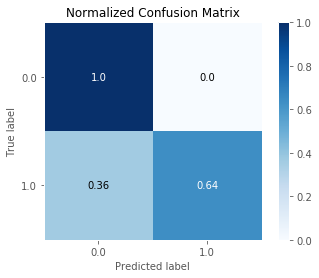

In [52]:
import scikitplot as skplt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import classification_report

# treinando metricas
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('Accurracy do modelo nos dados de treino: {}'.format(scores[1]))

y_pred=model.predict_classes(X_test)
print('\n[Classification Report]')
print("Accuracy do modelo nos dados de teste: {:.2f}".format(accuracy_score(y_test,y_pred)))
# imprimir a área sob da curva AUC
print("AUC: {:.2f}\n".format(roc_auc_score(y_test,y_pred)))

print(classification_report(y_test,y_pred))


skplt.metrics.plot_confusion_matrix(y_test,y_pred, normalize=True)

### Probabilidade de falha

Iremos prever a probabilidade de quebras das machines(maquina/turninas) em 30 dias, onde na váriavel machine_id, identifico a ID do equipamento.

In [53]:
def prob_failure(machine_id):
    machine_df=df_test[df_test.id==machine_id]
    machine_test=gen_sequence(machine_df,seq_length,seq_cols)
    m_pred=model.predict(machine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob

machine_id=20
print('Probabilidade de falha em 30 dias: ',prob_failure(machine_id))

Probabilidade de falha em 30 dias:  98.173965
